# Decision tree from scratch

In [1]:
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from IPython.display import Image, display_svg, SVG
#from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
#from sklearn.inspection import plot_partial_dependence
#from fastbook import *
#import warnings
#warnings.simplefilter('ignore', FutureWarning)
#from treeinterpreter import treeinterpreter
#from waterfall_chart import plot as waterfall

In [2]:
import zipfile,kaggle
path = Path('camnugent/california-housing-prices')
kaggle.api.dataset_download_cli(str(path))
zipfile.ZipFile(f'california-housing-prices.zip').extractall(path)

california-housing-prices.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#1) [Path('housing.csv')]

In [5]:
df = pd.read_csv(path/'housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
ocean2num = dict(zip(df.ocean_proximity.unique(), range(5))) # pd.Categorical(df_copy['ocean_proximity']) or df_copy['ocean_proximity'].cat.codes
log = ['total_rooms', 'total_bedrooms', 'population', 'households']

df_copy = df.copy()
df_copy[log] = np.log(df_copy[log])
df_copy['ocean_proximity'] = df_copy['ocean_proximity'].map(ocean2num)
df_copy.fillna(df_copy.mode().iloc[0], inplace=True)
dep = df_copy['median_house_value']

df_copy.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,6.779922,4.859812,5.774552,4.836282,8.3252,452600.0,0
1,-122.22,37.86,21.0,8.867709,7.008505,7.783641,7.037028,8.3014,358500.0,0
2,-122.24,37.85,52.0,7.290975,5.247024,6.206576,5.176150,7.2574,352100.0,0
3,-122.25,37.85,52.0,7.149917,5.459586,6.324359,5.389072,5.6431,341300.0,0
4,-122.25,37.85,52.0,7.394493,5.634790,6.336826,5.556828,3.8462,342200.0,0


In [8]:
def abs_err(pred, y):
    return np.abs(pred - y)

In [9]:
def mse_split(col, y, split):
    lhs = col <= split
    y_mean1 = y[lhs].mean()
    y_mean2 = y[~lhs].mean()
    return (abs_err(col[lhs], y_mean1).sum() + abs_err(col[~lhs], y_mean2).sum()) / len(y)

In [10]:
def min_err(df, col, y):
    temp = df[col].unique()
    del_max = np.delete(temp, temp.argmax())
    mse_min = np.array([mse_split(df[col], y, split) for split in del_max])
    min_idx = mse_min.argmin()
    return [mse_min[min_idx], df[col].unique()[min_idx]]

In [11]:
cols = np.delete(df_copy.columns, [-2, -1])

errs = np.array([min_err(df_copy, c, dep) for c in cols])

In [12]:
{cols[i]:errs[i] for i in range(len(cols))}

{'longitude': array([ 2.06975387e+05, -1.22230000e+02]),
 'latitude': array([2.06820185e+05, 3.84500000e+01]),
 'housing_median_age': array([2.06827177e+05, 2.50000000e+01]),
 'total_rooms': array([2.06848188e+05, 6.63331843e+00]),
 'total_bedrooms': array([2.06849770e+05, 7.22693602e+00]),
 'population': array([2.06848793e+05, 5.95064255e+00]),
 'households': array([2.06849836e+05, 7.48493028e+00]),
 'median_income': array([2.06851946e+05, 8.32520000e+00])}

In [13]:
def decision_tree(errs, df, y):
    min_idx = errs[:,0].argmin()
    col = df[cols[min_idx]]
    lhs = col <= errs[min_idx,1]
    df1 = df[lhs]
    df2 = df[~lhs]
    y1 = y[lhs]
    y2 = y[~lhs]
    errs1 = np.array([min_err(df1, c, y1) for c in cols])
    errs2 = np.array([min_err(df2, c, y2) for c in cols])
    return errs1, errs2

In [185]:
decision_tree(errs, df_copy, dep)

(array([[ 2.16843660e+05, -1.22230000e+02],
        [ 2.16695263e+05,  8.00000000e+00],
        [ 2.16716719e+05,  8.34045601e+00],
        [ 2.16718297e+05,  7.62217459e+00],
        [ 2.16717302e+05,  6.04737218e+00],
        [ 2.16718355e+05,  7.75061473e+00],
        [ 2.16720378e+05,  2.97090000e+00]]),
 array([[ 1.21487309e+05, -1.19780000e+02],
        [ 1.21340728e+05,  4.00000000e+00],
        [ 1.21357884e+05,  7.63094658e+00],
        [ 1.21359494e+05,  5.27299956e+00],
        [ 1.21358672e+05,  7.71556953e+00],
        [ 1.21359633e+05,  5.83481074e+00],
        [ 1.21362498e+05,  1.67850000e+00]]))

# Decision tree using libraries

In [15]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [52]:
log = ['total_rooms', 'total_bedrooms', 'population', 'households']

df_tree = df.copy()
df_tree[log] = np.log(df_tree[log])
dep = 'median_house_value'

In [96]:
procs = [Categorify, FillMissing]
cat = ['ocean_proximity']
cont = list(set(cont).difference(cat+[dep]))

to = TabularPandas(df_tree, procs, cat, cont, dep, RegressionBlock(), RandomSplitter()(df_tree), reduce_memory=False)

In [97]:
X, y = to.train.xs, to.train.y
X_valid, y_valid = to.valid.xs, to.valid.y

In [98]:
to.valid.xs.columns

Index(['ocean_proximity', 'total_bedrooms_na', 'total_rooms', 'households',
       'total_bedrooms', 'housing_median_age', 'population', 'median_income',
       'longitude', 'latitude'],
      dtype='object')

In [103]:
m = RandomForestRegressor(min_samples_leaf=5).fit(X, y)
preds = m.predict(X_valid)
abs_err(preds, y_valid).mean()

32370.39102893499

In [100]:
imp = pd.DataFrame({'cols':X.columns, 'imp':m.feature_importances_}).sort_values('imp',ascending=False)

<AxesSubplot:ylabel='cols'>

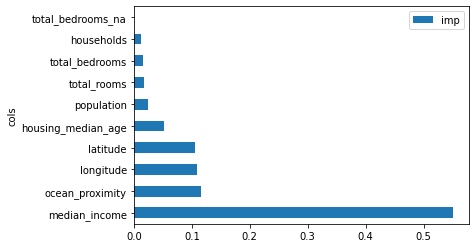

In [101]:
imp.set_index('cols').plot(kind='barh')